<a href="https://colab.research.google.com/github/sgcortes/2023_NAPLES/blob/main/Ex5_2_CNN_MULTI_CLASSIFICATION_rgb_SENTINEL2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
  <tr>
    <td><img src="https://unioviedo-my.sharepoint.com/:i:/g/personal/sgcortes_uniovi_es/Ebr0ybKDTBNKtoJyzmTBuRYBXY7nE-cCYaH-WDIVJxEVWA?&download=1" width="211" height="69" alt="Uniovi & EP Mieres logos" title="Uniovi & EP Mieres logos" /></td>
    <td><font color=brown>Deep Learning<br></font>
    <font color=green>Universidad de Oviedo. <br>ML & DL Naples 2023</font> <br><br>sgcortes@uniovi.es</td>
  </tr>
</table>

## Instance Multiclass Classification Example with CNN (Convolutional Neural Networks)
In this example the dataset from the file EUROSAT.zip will be clssified using a MLP. Images are RGB 64x64 pixels size. These tiles are stored in folder which names are the real class name they belong to.  

The original dataset can be dowloaded also from: http://madm.dfki.de/downloads
There are about 27.000 RGB subimages from Sentinel 2 imagery in this dataset.

In [1]:
# ESTA CELDA SOLO SE DEBE EJECUTAR UNA VEZ PARA DESCARGAR LOS DATOS. SI SE PIERDE LA CONEXIÓN DEL LIBRO PRO INACTIVIDAD SE DEBERÁ EJECUTAR DE NUEVO.
#!wget http://madm.dfki.de/files/sentinel/EuroSAT.zip
#!pip install tensorflow==2.2.0
# Las dos líneas anteriores no serán necesarias en general ya que TensorFlow está instalado por defecto en Google Colab y el enlace siguiente a uniovi shaorepoint funciona para descargar los datos. 
!wget -O EuroSAT.zip 'https://unioviedo-my.sharepoint.com/:u:/g/personal/sgcortes_uniovi_es/ESV-U5iHa_FIu2WVnU_Ysu0BLFb1BX1hzvzTFbivXLj1ZA?e=GOfJP9&download=1'
!unzip -qq EuroSAT.zip
%cd 2750

#NOTE: RUN THIS CELL ONLY ONCE. After first execution the dataset should be locally in the Google sesion content folder. Then comment the 3 commands of the cell.

--2023-05-26 08:05:37--  https://unioviedo-my.sharepoint.com/:u:/g/personal/sgcortes_uniovi_es/ESV-U5iHa_FIu2WVnU_Ysu0BLFb1BX1hzvzTFbivXLj1ZA?e=GOfJP9&download=1
Resolving unioviedo-my.sharepoint.com (unioviedo-my.sharepoint.com)... 52.107.252.14, 52.107.252.25, 52.107.252.24, ...
Connecting to unioviedo-my.sharepoint.com (unioviedo-my.sharepoint.com)|52.107.252.14|:443... connected.
HTTP request sent, awaiting response... 302 
Location: /personal/sgcortes_uniovi_es/Documents/2020_VISION/EuroSAT.zip?ga=1 [following]
--2023-05-26 08:05:38--  https://unioviedo-my.sharepoint.com/personal/sgcortes_uniovi_es/Documents/2020_VISION/EuroSAT.zip?ga=1
Reusing existing connection to unioviedo-my.sharepoint.com:443.
HTTP request sent, awaiting response... 200 OK
Length: 94280567 (90M) [application/x-zip-compressed]
Saving to: ‘EuroSAT.zip’

EuroSAT.zip         100%[===================>]  89.91M  1.65MB/s    in 56s     

2023-05-26 08:06:35 (1.60 MB/s) - ‘EuroSAT.zip’ saved [94280567/94280567]

/co

In [2]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import keras


## Loading data
ruta_datos = '/content/2750/'
clases = os.listdir(ruta_datos)
print(f"List of class names:\n", clases)

List of class names:
 ['AnnualCrop', 'Forest', 'SeaLake', 'River', 'Highway', 'Pasture', 'Residential', 'PermanentCrop', 'Industrial', 'HerbaceousVegetation']


We need to store the data in arrays (tensors) with the following structure dimensions: _[#_images, #_filas #_cols, #_channels]_

In [3]:
dic_clases = {}
datos_entrada = []
datos_salida = []
i=0

for i, clase in enumerate(clases):
    if os.path.isdir(ruta_datos+clase):
        for file in os.listdir(ruta_datos+clase):
            im = Image.open(os.path.join(ruta_datos, clase, file))
            im_array = np.array(im)
            datos_entrada.append(im_array)
            datos_salida.append(i)
        dic_clases[i] = clase
        
datos_entrada = np.array(datos_entrada)
datos_salida = np.array(datos_salida)

print(f'Feature matrix dims:\n',datos_entrada.shape)
print(f'Class label vector dims:\n',datos_salida.shape) # New class label

Feature matrix dims:
 (27000, 64, 64, 3)
Class label vector dims:
 (27000,)


Display of one land cover image from of each class:

Index of the displayed image examples:
 [0, 3000, 6000, 9000, 11500, 14000, 16000, 19000, 21500, 24000]


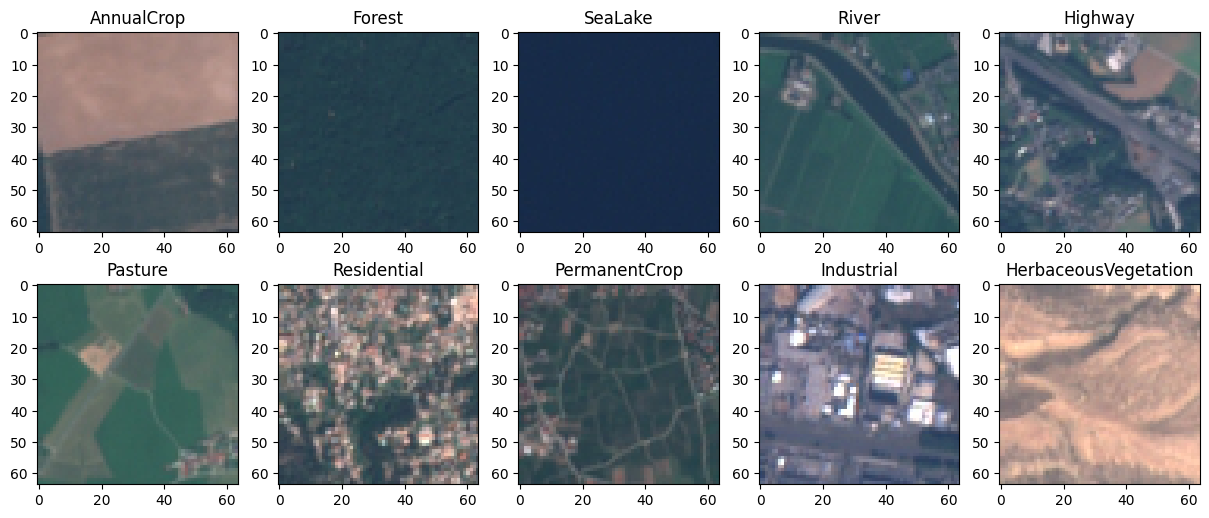

In [4]:
ind_ejemplos = [np.where(datos_salida == i)[0][0] for i in range(10)]
print('Index of the displayed image examples:\n',ind_ejemplos)
fig, axs = plt.subplots(2,5, figsize=(15,6))
axs = axs.ravel()
for i,ax in enumerate(axs):
    axs[i].imshow(datos_entrada[ind_ejemplos[i]])
    axs[i].set_title(clases[i])

In [5]:
print(f'Class labels:\n',np.unique(datos_salida))

Class labels:
 [0 1 2 3 4 5 6 7 8 9]


### Splitting data for training and testing and one hot encoding for class labels

In [6]:
from sklearn.model_selection import train_test_split
x_train, x_test, clases_train, clases_test = train_test_split(datos_entrada,
                                                           datos_salida,
                                                           train_size=0.8,
                                                           random_state=1,
                                                           shuffle=True)

# convertir la salida a foramto "one-hot"
y_train = keras.utils.to_categorical(clases_train)
y_test = keras.utils.to_categorical(clases_test)

### Normalizing Digital Numbers from images

In [7]:
# Imáge normalization
x_train = x_train/255
x_test =x_test/255

In [8]:
# Checking data sizes:
print(f'Feature matrix Training set dims:\n',x_train.shape)
print(f'Feature matrix Test set dims:\n',x_test.shape)

print(f'Class label vector Training set dims:\n',y_train.shape)
print(f'Class label vector Test set dims:\n',y_test.shape)

Feature matrix Training set dims:
 (21600, 64, 64, 3)
Feature matrix Test set dims:
 (5400, 64, 64, 3)
Class label vector Training set dims:
 (21600, 10)
Class label vector Test set dims:
 (5400, 10)


### Model 1: CNN, Convolutional Neural Network
A efectos de comparación de las métricas de desempeño podemos emplear como punto de comparación un modelo CNN

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D
from keras.layers import MaxPooling2D, Flatten


cnn = Sequential()
cnn.add(Conv2D(64, 5, strides = (2,2),
              activation='relu',
              padding = 'same',
              input_shape = (64,64,3)))

cnn.add(Conv2D(64, 3, strides = (2,2),
              activation='relu',
              padding = 'same'))

cnn.add(Conv2D(64, 3, strides = (2,2),
              activation='relu',
              padding = 'same'))

cnn.add(Flatten())       
cnn.add(Dense(50, activation = 'relu'))
cnn.add(Dense(10, activation = 'softmax'))
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        4864      
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 50)                204850    
                                                                 
 dense_1 (Dense)             (None, 10)                510       
                                                                 
Total params: 284,080
Trainable params: 284,080
Non-trai

In [10]:
cnn.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [11]:
hist = cnn.fit(x_train, y_train,
               epochs =25,
               batch_size =256,
               validation_data=(x_test, y_test))

Epoch 1/25
85/85 [==============================] - 15s 43ms/step - loss: 1.8015 - accuracy: 0.3166 - val_loss: 1.5619 - val_accuracy: 0.4339
Epoch 2/25
85/85 [==============================] - 2s 23ms/step - loss: 1.4528 - accuracy: 0.4685 - val_loss: 1.3982 - val_accuracy: 0.5052
Epoch 3/25
85/85 [==============================] - 2s 23ms/step - loss: 1.2012 - accuracy: 0.5733 - val_loss: 1.0900 - val_accuracy: 0.6122
Epoch 4/25
85/85 [==============================] - 2s 26ms/step - loss: 1.0163 - accuracy: 0.6442 - val_loss: 1.0651 - val_accuracy: 0.6133
Epoch 5/25
85/85 [==============================] - 2s 27ms/step - loss: 0.9094 - accuracy: 0.6811 - val_loss: 0.9922 - val_accuracy: 0.6459
Epoch 6/25
85/85 [==============================] - 2s 24ms/step - loss: 0.8295 - accuracy: 0.7089 - val_loss: 0.8241 - val_accuracy: 0.7106
Epoch 7/25
85/85 [==============================] - 2s 24ms/step - loss: 0.7652 - accuracy: 0.7312 - val_loss: 0.8237 - val_accuracy: 0.7102
Epoch 8/25
8

### Accuracy and cost function graphics

In [12]:
def plot_AccAndLoss(hist):
  fig1 = plt.figure()
  plt.plot(hist.history['accuracy'],label='Accuracy')
  plt.grid()
  plt.title('Accuracy & Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy & Loss')
  plt.plot(hist.history['loss'],label='Loss function');
  plt.legend()

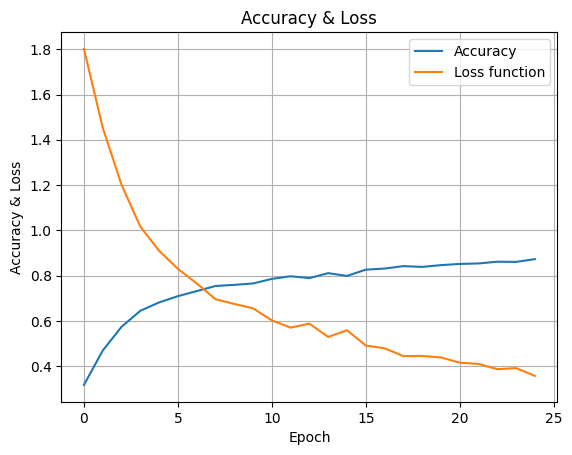

In [13]:
plot_AccAndLoss(hist)

## MaxPooling
Adding Max pooling can allow us to increase the number of "filters" in each layer 

In [14]:
cnn2 = Sequential()
cnn2.add(Conv2D(128, 5, strides = (2,2),
              activation='relu',
              padding = 'same',
              input_shape = (64,64,3)))
cnn2.add(MaxPooling2D(pool_size=2))

cnn2.add(Conv2D(128, 3, strides = (2,2),
              activation='relu',
              padding = 'same'))
cnn2.add(MaxPooling2D(pool_size=2))

cnn2.add(Conv2D(128, 3, strides = (2,2),
              activation='relu',
              padding = 'same'))
cnn2.add(MaxPooling2D(pool_size=2))

cnn2.add(Flatten())       
cnn2.add(Dense(50, activation = 'relu'))
cnn2.add(Dense(10, activation = 'softmax'))
cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 128)       9728      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 128)      0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4, 4, 128)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 2, 128)         147584    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 1, 1, 128)       

In [15]:
cnn2.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [16]:
hist = cnn2.fit(x_train, y_train,
               epochs =25,
               batch_size =512,
               validation_data=(x_test, y_test))

Epoch 1/25
43/43 [==============================] - 6s 79ms/step - loss: 1.9224 - accuracy: 0.2638 - val_loss: 1.7165 - val_accuracy: 0.3519
Epoch 2/25
43/43 [==============================] - 2s 51ms/step - loss: 1.5224 - accuracy: 0.4443 - val_loss: 1.4641 - val_accuracy: 0.4957
Epoch 3/25
43/43 [==============================] - 2s 51ms/step - loss: 1.3629 - accuracy: 0.5118 - val_loss: 1.2532 - val_accuracy: 0.5717
Epoch 4/25
43/43 [==============================] - 2s 55ms/step - loss: 1.2004 - accuracy: 0.5717 - val_loss: 1.2219 - val_accuracy: 0.5591
Epoch 5/25
43/43 [==============================] - 2s 52ms/step - loss: 1.1539 - accuracy: 0.5816 - val_loss: 1.1040 - val_accuracy: 0.5919
Epoch 6/25
43/43 [==============================] - 2s 51ms/step - loss: 1.0868 - accuracy: 0.6014 - val_loss: 1.0725 - val_accuracy: 0.6137
Epoch 7/25
43/43 [==============================] - 2s 50ms/step - loss: 1.0215 - accuracy: 0.6288 - val_loss: 1.0439 - val_accuracy: 0.6126
Epoch 8/25
43

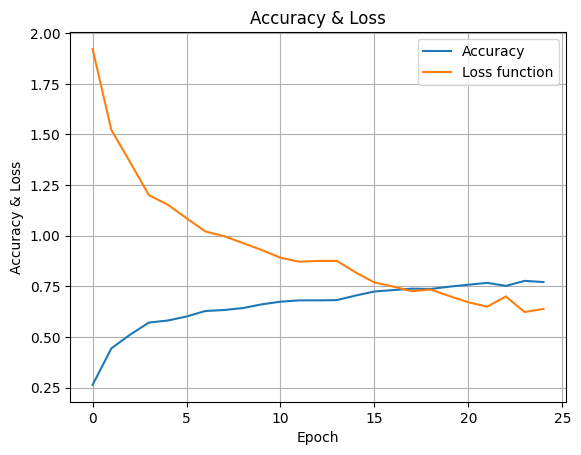

In [17]:
plot_AccAndLoss(hist)

## Training and Validation precisions. (Inner and external precisions)

In [18]:
acc_train = cnn2.evaluate(x_train, y_train)[1]*100
acc_test = cnn2.evaluate(x_test, y_test)[1]*100

print('Training accuracy: ', format(acc_train, '.2f'), '%')
print('Test accuracy: ', format(acc_test, '.2f'), '%')

169/169 [==============================] - 1s 5ms/step - loss: 0.6649 - accuracy: 0.7681
Training accuracy:  78.07 %
Test accuracy:  76.81 %


## Model Validation
Let´s see the confusion matrix for test and training sets.

In [19]:
y_prob_train = cnn2.predict(x_train)
y_prob_test = cnn2.predict(x_test)

y_pred_train = np.argmax(y_prob_train, axis=1)
y_pred_test = np.argmax(y_prob_test, axis=1)
print(y_pred_train[0:5])

169/169 [==============================] - 1s 3ms/step
[6 0 1 2 4]


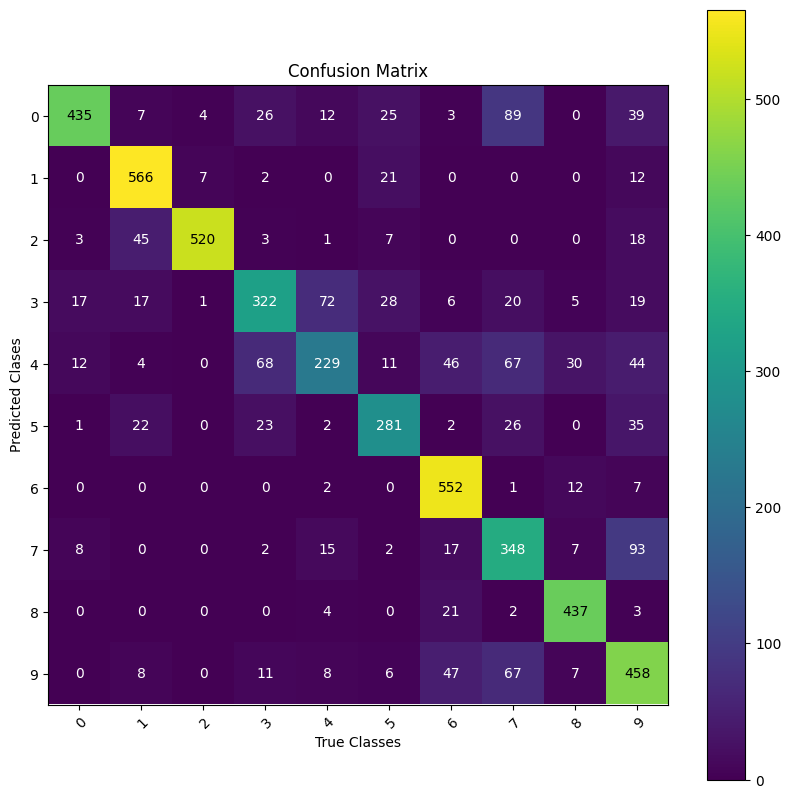

In [20]:
from sklearn.metrics import confusion_matrix

# Confusion Matrix

cm = confusion_matrix(clases_test,y_pred_test)

# confusion matrix Graphics

clases = np.unique(clases_test)
fig,ax = plt.subplots(figsize=(10,10))
im = ax.imshow(cm, interpolation='nearest')
ax.figure.colorbar(im, ax=ax)

# Add title and lables to the confusion matrix graphic
ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=clases, yticklabels=clases,
       title='Confusion Matrix',
       ylabel='Predicted Clases',
       xlabel='True Classes')

# Rota los nombres de las etiquetas en el eje x
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor")

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j,i, cm[i,j],
               ha="center", va="center",
               color="white" if cm[i,j] <350 else "black")
plt.show()

## Metrics: precision, recall, accuracy and F1

In [21]:
from sklearn.metrics import accuracy_score, precision_score
from sklearn.metrics import f1_score, recall_score

acc_train = accuracy_score(clases_train, y_pred_train)
acc_test = accuracy_score(clases_test, y_pred_test)

prec_train = precision_score(clases_train, y_pred_train, average='macro')
prec_test = precision_score(clases_test, y_pred_test, average='macro')

rec_train = recall_score(clases_train, y_pred_train, average='macro')
rec_test = recall_score(clases_test, y_pred_test, average='macro')

f1_train = f1_score(clases_train, y_pred_train, average='macro')
f1_test = f1_score(clases_test, y_pred_test, average='macro')

print('Training Accuracy: ', format(100*acc_train, '.2f'),'%')
print('Validation Accuracy: ', format(100*acc_test, '.2f'),'\n')


print('Training Precision: ', format(100*prec_train, '.2f'),'%')
print('Validation Precision: ', format(100*prec_test, '.2f'),'\n')

print('Training Recall: ', format(100*rec_train, '.2f'),'%')
print('Validation Recall: ', format(100*rec_test, '.2f'),'\n')

print('Training F1: ', format(f1_train, '.3f'))
print('Validation F1: ', format(f1_test, '.3f'),'\n')

Training Accuracy:  78.07 %
Validation Accuracy:  76.81 

Training Precision:  78.32 %
Validation Precision:  77.07 

Training Recall:  77.20 %
Validation Recall:  76.35 

Training F1:  0.772
Validation F1:  0.760 



## Displaying some predictions

169/169 [==============================] - 0s 3ms/step
Probability values:
 [[4.03589984e-05 2.36103870e-06 5.45426417e-07 3.16119310e-03
  4.28101094e-03 2.66771968e-02 4.25637187e-03 9.34823513e-01
  1.20656605e-05 2.67454553e-02]
 [3.05427402e-01 5.53075961e-06 7.39506561e-07 1.16953444e-04
  1.33323491e-01 2.77748532e-05 2.72859797e-08 1.28412604e-01
  2.03516047e-05 4.32665110e-01]
 [7.01534152e-02 6.20268867e-04 2.82526202e-03 8.71613801e-01
  2.79351678e-02 1.82411924e-04 2.84437701e-05 2.53390092e-02
  2.06547668e-08 1.30216323e-03]
 [9.86863256e-01 1.52775760e-06 2.05082138e-08 7.80626549e-04
  6.54499093e-03 1.36839735e-04 3.78038129e-10 1.40790897e-03
  6.50108007e-07 4.26411489e-03]]
[7 9 3 0]
0
1
2
3


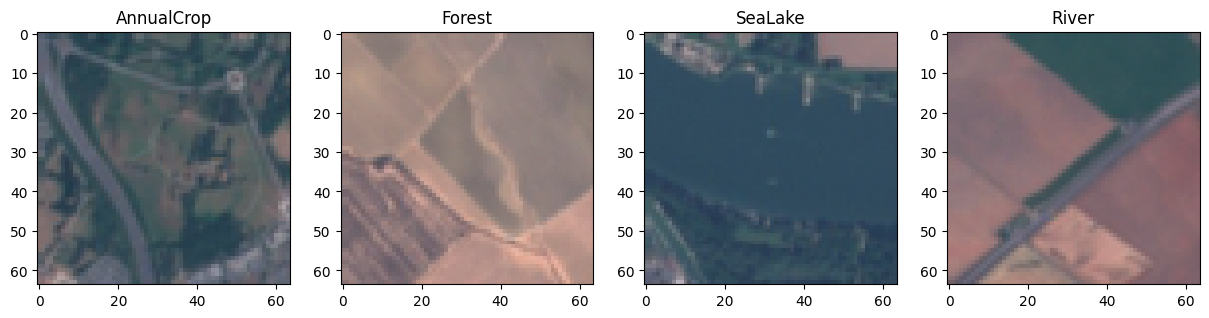

In [34]:
from keras.layers.convolutional.conv3d import Convolution3D
y_proba = cnn.predict(x_test)
num = [150,300,4, 1300]
print("Probability values:\n",y_proba[num])

# The highest probability value would be:
highp = np.argmax(y_proba[num],axis=1)
print(highp)
fig, axs = plt.subplots(1,4, figsize=(15,6))
axs = axs.ravel()
for i, val in enumerate(axs):
    print(i)
    axs[i].imshow(x_test[num[i]].reshape(64,64,3))
    axs[i].set_title(dic_clases[i])
    

# OTHER MODELS:
The precision metrics from the previous model are low. Please check some of the models below to get some inspiration and feel free to change add or insert  whatever hyperparameters you want. The goal is to improve matric values to get a better result....

### A deeper network
Let's make a deeper network

In [ ]:
cnn3 = Sequential()
cnn3.add(Conv2D(16, 5,activation='relu',padding = 'same',input_shape = (64,64,3)))
cnn3.add(Conv2D(16, 5, strides = (2,2),activation='relu',padding = 'same',input_shape = (64,64,3)))
cnn3.add(MaxPooling2D(pool_size=2))

cnn3.add(Conv2D(256, 3,activation='relu',padding = 'same'))
cnn3.add(Conv2D(256, 3, strides = (2,2),
              activation='relu',
              padding = 'same'))
cnn3.add(MaxPooling2D(pool_size=2))

cnn3.add(Conv2D(512, 3,activation='relu',padding = 'same'))
cnn3.add(Conv2D(512, 3,activation='relu',padding = 'same'))
cnn3.add(MaxPooling2D(pool_size=2))

cnn3.add(Conv2D(1024, 3,activation='relu',padding = 'same'))
cnn3.add(Conv2D(1024, 3,activation='relu',padding = 'same'))
cnn3.add(MaxPooling2D(pool_size=2))

cnn3.add(Flatten()) 
cnn3.add(Dropout(0.4))
cnn3.add(Dense(50, activation = 'relu'))
cnn3.add(Dense(10, activation = 'softmax'))
cnn3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 16)        1216      
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 16)        6416      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 16, 16, 256)       37120     
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 256)         590080    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 4, 4, 256)        0         
 2D)                                                  

In [ ]:
cnn3.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
hist = cnn3.fit(x_train, y_train,
               epochs =15,
               batch_size =128,
               validation_data=(x_test, y_test))

Epoch 1/15
169/169 [==============================] - 22s 85ms/step - loss: 1.7686 - accuracy: 0.2807 - val_loss: 1.3988 - val_accuracy: 0.3841
Epoch 2/15
169/169 [==============================] - 12s 68ms/step - loss: 1.2265 - accuracy: 0.5301 - val_loss: 0.9123 - val_accuracy: 0.6709
Epoch 3/15
169/169 [==============================] - 11s 65ms/step - loss: 0.8985 - accuracy: 0.6727 - val_loss: 0.9616 - val_accuracy: 0.6589
Epoch 4/15
169/169 [==============================] - 11s 64ms/step - loss: 0.7632 - accuracy: 0.7252 - val_loss: 0.6651 - val_accuracy: 0.7509
Epoch 5/15
169/169 [==============================] - 11s 64ms/step - loss: 0.6421 - accuracy: 0.7681 - val_loss: 0.6548 - val_accuracy: 0.7700
Epoch 6/15
169/169 [==============================] - 11s 67ms/step - loss: 0.5642 - accuracy: 0.7994 - val_loss: 0.5202 - val_accuracy: 0.8067
Epoch 7/15
169/169 [==============================] - 11s 66ms/step - loss: 0.5146 - accuracy: 0.8158 - val_loss: 0.5111 - val_accuracy:

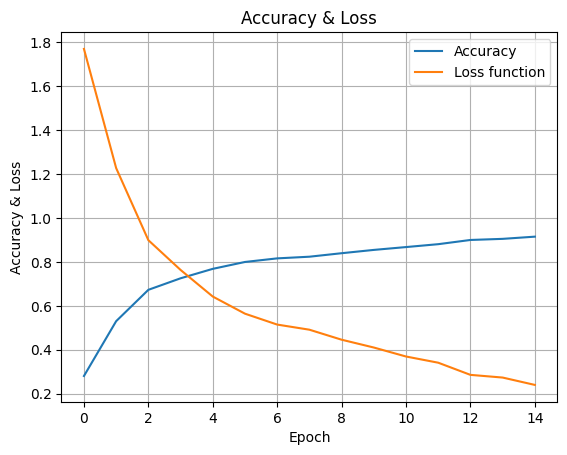

In [ ]:
plot_AccAndLoss(hist)

## Batch Normalization

In [ ]:
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D
from keras.layers import MaxPooling2D, Flatten

cnn4 = Sequential()
cnn4.add(Conv2D(16, 5,activation='relu',padding = 'same',input_shape = (64,64,3)))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(16, 5,activation='relu',padding = 'same',input_shape = (64,64,3)))
cnn4.add(MaxPooling2D(pool_size=2))

cnn4.add(Conv2D(32, 3,activation='relu',padding = 'same'))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(32, 3,activation='relu',padding = 'same'))
cnn4.add(MaxPooling2D(pool_size=2))

cnn4.add(Conv2D(64, 3,activation='relu',padding = 'same'))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(64, 3,activation='relu',padding = 'same'))
cnn4.add(MaxPooling2D(pool_size=2))

cnn4.add(Conv2D(128, 3,activation='relu',padding = 'same'))
cnn4.add(BatchNormalization())
cnn4.add(Conv2D(128, 3,activation='relu',padding = 'same'))
cnn4.add(MaxPooling2D(pool_size=2))

cnn4.add(Flatten()) 
cnn4.add(Dropout(0.4))
cnn4.add(Dense(50, activation = 'relu'))
cnn4.add(Dense(10, activation = 'softmax'))
cnn4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        1216      
                                                                 
 batch_normalization (BatchN  (None, 64, 64, 16)       64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        6416      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        4640      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       1

In [ ]:
cnn4.compile(optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
hist4 = cnn4.fit(x_train, y_train,
               epochs =25,
               batch_size =256,
               validation_data=(x_test, y_test))

NameError: ignored